In [51]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.stats import norm, lognorm
from astroML.utils import log_multivariate_gaussian
import emcee
from schwimmbad import MultiPool

$$
y_{\rm true} = a\,x + b + c_1\,\cos\left(2\pi\,t/P\right) + c_2\,\sin\left(2\pi\,t/P\right)
$$

In [52]:
def eval_model(a, b, c1, c2, P, t):
    return a * t + b + c1 * np.cos(2*np.pi*t / P) + c2 * np.sin(2*np.pi*t / P)

In [62]:
rnd = np.random.RandomState(seed=42)  # what else?

N = 5

t = np.sort(rnd.uniform(-5, 5, N))
true_y = eval_model(a=rnd.uniform(-1, 1),
                    b=rnd.uniform(1, 10),
                    c1=rnd.uniform(0, 1),
                    c2=rnd.uniform(0, 1),
                    P=rnd.uniform(1, 3),
                    t=t)

y_err = rnd.uniform(0.1, 0.2, size=N)
y = rnd.normal(true_y, y_err)

<ErrorbarContainer object of 3 artists>

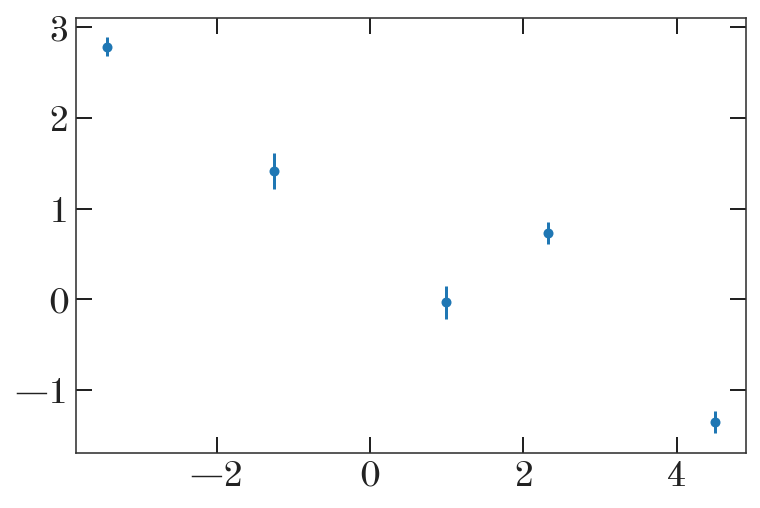

In [63]:
plt.errorbar(t, y, y_err, 
             marker='o', ls='none')

In [64]:
def design_matrix(P, t):
    M = np.stack((t, 
                  np.ones_like(t), 
                  np.cos(2*np.pi*t/P),
                  np.sin(2*np.pi*t/P)), 
                 axis=1)
    return M

In [65]:
C = np.diag(y_err ** 2)
mu = np.array([0., 0, 0, 0])
L = np.diag([0.1, 10, 1, 1]) ** 2

In [1]:
def get_aAbB(y, C, M, mu, L):
    Linv = np.linalg.inv(L)
    Cinv = np.linalg.inv(C)

    b = M @ mu
    B = C + M @ L @ M.T

    Ainv = Linv + M.T @ Cinv @ M
    A = np.linalg.inv(Ainv)
    Binv = Cinv - Cinv @ M @ A @ M.T @ Cinv
    a = np.linalg.solve(Ainv, Linv @ mu + M.T @ Cinv @ y)
    
    loglike = log_multivariate_gaussian(y, b, B, Vinv=Binv)

    return {
        'a': a, 'A': A,
        'b': b, 'B': B,
        'ln_marg_likelihood': loglike
    }

In [68]:
def ln_likelihood(P, t, y, C, mu, L):
    M = design_matrix(P, t)
    res = get_aAbB(y, C, M, mu, L)
    return res['ln_marg_likelihood']

In [76]:
def make_full_sample(P, t, y, C, mu, L):
    M = design_matrix(P, t)
    res = get_aAbB(y, C, M, mu, L)
    linear_sample = np.random.multivariate_normal(res['a'], res['A'])
    return np.concatenate((linear_sample, [P]))

In [71]:
n_prior_samples = 100_000
prior_samples = 10 ** rnd.uniform(-1, 2, size=n_prior_samples)

In [72]:
marg_lnlikes = np.array([ln_likelihood(P, t, y, C, mu, L) 
                         for P in prior_samples])

In [73]:
mask = np.exp(marg_lnlikes - marg_lnlikes.max()) > rnd.uniform(size=n_prior_samples)
mask.sum()

574

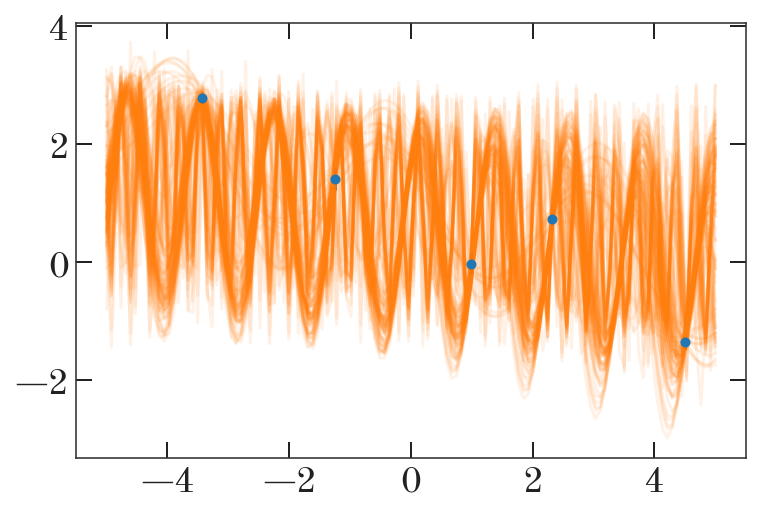

In [79]:
plt.errorbar(t, y, y_err, 
             marker='o', ls='none')

grid_t = np.linspace(-5, 5, 128)
for p in prior_samples[mask][:128]:
    full_sample = make_full_sample(p, t, y, C, mu, L)
    plt.plot(grid_x, eval_model(*full_sample, t=grid_t),
             marker='', alpha=0.1, color='tab:orange')

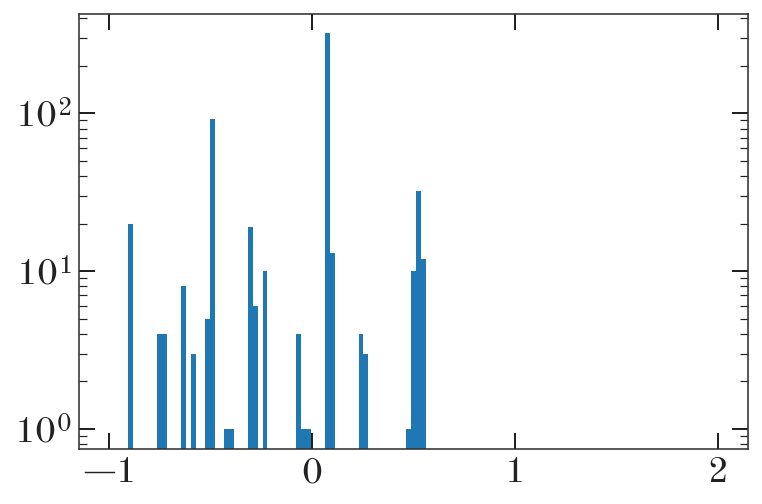

In [81]:
plt.hist(np.log10(prior_samples[mask]), 
         bins=np.linspace(-1, 2, 128));
plt.yscale('log')